# Lesson 6 Assignment - Ensemble Techniques
Version: July-2020

## Author - Priya Asokan

## Instructions
1. Read in, parse, and pre-process the data
2. Perform a brief exploratory analysis
3. Compare the performance between a decision tree and a random forest approach by assessing the accuracy of each model
4. Graph the structure of your decision tree
5. Graph the confusion matrix of your random forest model


## Summary
### EDA
-  From correlation matrix, we see that Income and age are highly correlated.
2. Older age customers have a higher income
3. More number of male customers are likely to say yes to the campaign than the female customers.
4. Customers with an income of more than 2500 are likely to say Yes for the campaign
5. Customers with a mortgage and married are more likely to say yes for the campaign.
6. Customers who have 1 children are more likely to say yes to the campaign.
7. Customers who dont have a mortgage and have a income of more than 3000 are likely to say yes to the campaign.
### Performance of each model
- The best parameters from tuning using GridSearchCV. 
    {'criterion': 'entropy', 'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 50}
- Accuracy Scores for each model are listed below -
1. Random Forest Classifier - 0.83 confusion Matrix (True Positiove -41, False Negative- 6, False Positive-9,True Negative-34)
2. Decision Tree Classifier using bagging Ensemble technique - 0.88
3. Decision Tree Classifier using ada boosting Ensemble technique - 0.76
4. Decision Tree Classifier using gradient boosting Ensemble technique -0.80
- From the above accuracy scores, Decsion Tree classifier using bagging Ensemble technique performs well and it is applied to test model.
- Accuracy scores for Test model -0.88 and AUC - 0.90


In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import os
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.tree import plot_tree

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score

In [2]:
SEED = 2005

In [3]:
# Read Data to a pandas dataframe
url = 'https://raw.githubusercontent.com/PriyaVj-DS/Assignments/master/datasets/Bank%20Data.csv'
bank_df = pd.read_csv(url)

In [4]:
bank_df.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


In [5]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          600 non-null    int64  
 1   sex          600 non-null    object 
 2   region       600 non-null    object 
 3   income       600 non-null    float64
 4   married      600 non-null    object 
 5   children     600 non-null    int64  
 6   car          600 non-null    object 
 7   save_act     600 non-null    object 
 8   current_act  600 non-null    object 
 9   mortgage     600 non-null    object 
 10  pep          600 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 51.7+ KB


In [6]:
print(bank_df.isnull().sum())

age            0
sex            0
region         0
income         0
married        0
children       0
car            0
save_act       0
current_act    0
mortgage       0
pep            0
dtype: int64


In [7]:
bank_df.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,NO,1,NO,NO,NO,NO,YES
1,40,MALE,TOWN,30085.1,YES,3,YES,NO,YES,YES,NO
2,51,FEMALE,INNER_CITY,16575.4,YES,0,YES,YES,YES,NO,NO
3,23,FEMALE,TOWN,20375.4,YES,3,NO,NO,YES,NO,NO
4,57,FEMALE,RURAL,50576.3,YES,0,NO,YES,NO,NO,NO


In [8]:
# Replace yes/no with 1/0
def replaceYesNoWithZerosAndOne(col):
    bank_df[col] = bank_df[col].apply(lambda x: 0 if x=='NO' else 1)
    
replaceYesNoWithZerosAndOne('married')
replaceYesNoWithZerosAndOne('car')
replaceYesNoWithZerosAndOne('save_act')
replaceYesNoWithZerosAndOne('current_act')
replaceYesNoWithZerosAndOne('mortgage')
replaceYesNoWithZerosAndOne('pep')

In [9]:
bank_df.head()

,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
0,48,FEMALE,INNER_CITY,17546.0,0,1,0,0,0,0,1
1,40,MALE,TOWN,30085.1,1,3,1,0,1,1,0
2,51,FEMALE,INNER_CITY,16575.4,1,0,1,1,1,0,0
3,23,FEMALE,TOWN,20375.4,1,3,0,0,1,0,0
4,57,FEMALE,RURAL,50576.3,1,0,0,1,0,0,0


In [10]:
bank_df.dtypes

age              int64
sex             object
region          object
income         float64
married          int64
children         int64
car              int64
save_act         int64
current_act      int64
mortgage         int64
pep              int64
dtype: object

In [11]:
bank_df['sex'].unique()

array(['FEMALE', 'MALE'], dtype=object)

In [12]:
# Decode values for Male & Female
bank_df.loc[bank_df.loc[:, "sex"] == 'FEMALE', "sex"] = 1
bank_df.loc[bank_df.loc[:, "sex"] == 'MALE', "sex"] = 2

In [13]:
bank_df['region'].unique()

array(['INNER_CITY', 'TOWN', 'RURAL', 'SUBURBAN'], dtype=object)

In [14]:
# One hot encode Embarked column
bank_df = pd.get_dummies(bank_df,columns = ['region'],dtype=int)

In [15]:
# Convert 'sex' column to 'int' data type
bank_df['sex'] = bank_df['sex'].astype('int')

In [16]:
print(bank_df.dtypes)

age                    int64
sex                    int32
income               float64
married                int64
children               int64
car                    int64
save_act               int64
current_act            int64
mortgage               int64
pep                    int64
region_INNER_CITY      int32
region_RURAL           int32
region_SUBURBAN        int32
region_TOWN            int32
dtype: object


In [17]:
bank_df.describe()

,age,sex,income,married,children,car,save_act,current_act,mortgage,pep,region_INNER_CITY,region_RURAL,region_SUBURBAN,region_TOWN
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,42.395000,1.500000,27524.031217,0.660000,1.011667,0.493333,0.690000,0.758333,0.348333,0.456667,0.448333,0.160000,0.103333,0.288333
std,14.424947,0.500417,12899.468246,0.474104,1.056752,0.500373,0.462879,0.428451,0.476840,0.498534,0.497738,0.366912,0.304648,0.453365
min,18.000000,1.000000,5014.210000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,1.000000,17264.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,1.500000,24925.300000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.250000,2.000000,36172.675000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,67.000000,2.000000,63130.100000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Exploratory Data Analysis

In [18]:
# Value of each class
bank_df['pep'].value_counts()

0    326
1    274
Name: pep, dtype: int64

In [19]:
# Correlation between all numerical variables
bank_df.corr()

,age,sex,income,married,children,car,save_act,current_act,mortgage,pep,region_INNER_CITY,region_RURAL,region_SUBURBAN,region_TOWN
age,1.000000,-0.090081,0.752726,0.010394,0.023572,0.077733,0.184389,-0.035312,-0.016154,0.173825,-0.025171,0.018635,0.031345,-0.008510
sex,-0.090081,1.000000,-0.023845,0.021110,-0.014206,0.006667,0.007207,-0.019466,0.066465,0.046843,0.023459,0.009092,0.010951,-0.040472
income,0.752726,-0.023845,1.000000,-0.008386,0.036761,0.081556,0.266164,0.031616,-0.014662,0.221991,-0.047564,0.084776,0.029824,-0.036431
married,0.010394,0.021110,-0.008386,1.000000,-0.048716,-0.009571,0.028604,-0.059996,-0.021711,-0.189578,0.003254,-0.022649,0.012483,0.006369
children,0.023572,-0.014206,0.036761,-0.048716,1.000000,0.036455,0.041536,0.006238,-0.074339,-0.057663,-0.051222,0.089902,-0.014122,-0.007033
car,0.077733,0.006667,0.081556,-0.009571,0.036455,1.000000,0.034310,-0.034783,-0.007743,0.018917,-0.018143,0.024006,-0.061184,0.041604
save_act,0.184389,0.007207,0.266164,0.028604,0.041536,0.034310,1.000000,0.042511,-0.001588,-0.072779,-0.091373,0.036960,0.002605,0.068654
current_act,-0.035312,-0.019466,0.031616,-0.059996,0.006238,-0.034783,0.042511,1.000000,-0.036704,0.025141,0.007894,-0.008496,0.038157,-0.027431
mortgage,-0.016154,0.066465,-0.014662,-0.021711,-0.074339,-0.007743,-0.001588,-0.036704,1.000000,-0.024182,0.002098,-0.051908,0.004635,0.036591
pep,0.173825,0.046843,0.221991,-0.189578,-0.057663,0.018917,-0.072779,0.025141,-0.024182,1.000000,0.001054,0.019714,0.062508,-0.059115


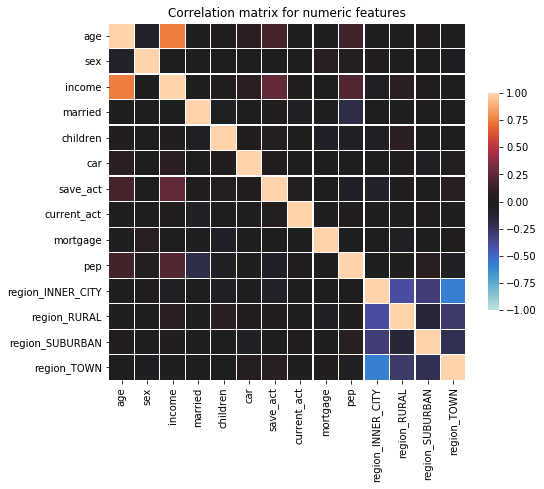

In [20]:
# HeatMap to show the correlation between the variables
plt.figure(figsize=(8, 8))
sns.heatmap(bank_df.corr(),vmax=1.0,vmin = -1, center=0,
            square=True, linewidths=.25, cbar_kws={"shrink": .5})
plt.title('Correlation matrix for numeric features')# Give the plot a main title
plt.yticks(rotation='horizontal') # Set text for x axis
plt.xticks(rotation='vertical') # Set text for y axis
plt.show()

##### From the above correlation matrix, we see that Income and age are highly correlated.


Text(0, 0.5, 'age')

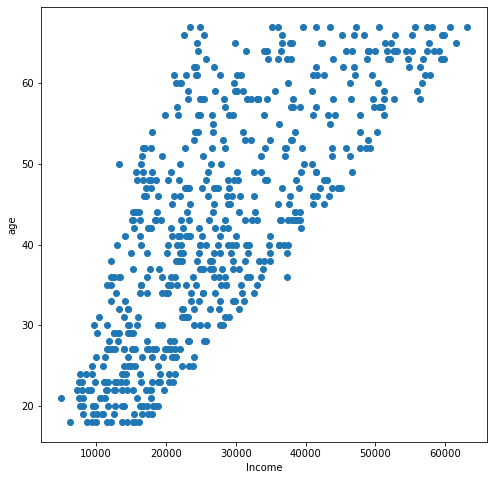

In [21]:
fig,ax = plt.subplots(figsize=(8,8))
plt.scatter(bank_df['income'],bank_df['age'])
plt.xlabel('Income')
plt.ylabel('age')

##### Older age customers have a higher income

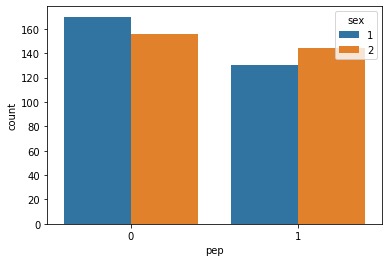

In [22]:
sns.countplot(x='pep',hue ='sex',data=bank_df)

##### More number of male customers are likely to say yes to the campaign than the female customers

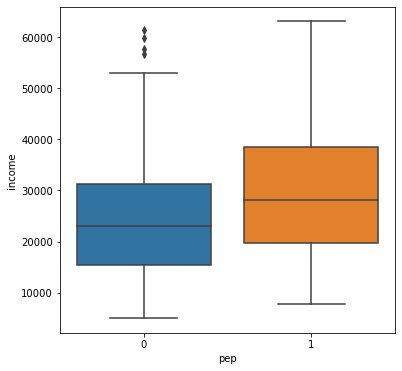

In [23]:
fig,ax = plt.subplots(figsize=(6,6))
sns.boxplot(bank_df['pep'],bank_df['income'])

##### Customers with an income of more than 2500 are likely to say Yes for the campaign

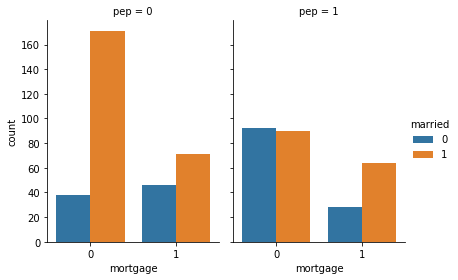

In [24]:
sns.catplot(x="mortgage", hue="married", col="pep",
                data=bank_df, kind="count",
                height=4, aspect=.7)

##### Customers with a mortgage and married are more likely to say yes for the campaign

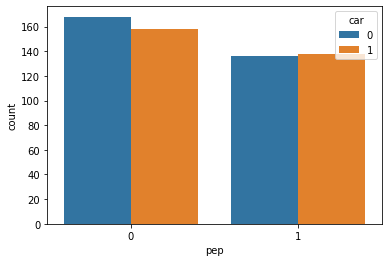

In [25]:
sns.countplot(x='pep',hue ='car',data=bank_df)

##### Count of customers with car or without car are same  who are not likely to say yes to the campaign

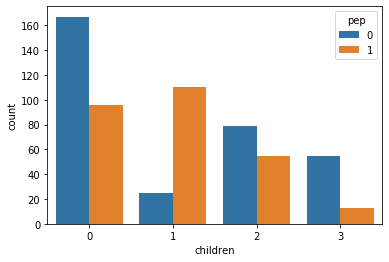

In [26]:
sns.countplot(x='children',hue ='pep',data=bank_df)

##### Customers who have 1 children are more likely to say yes to the campaign

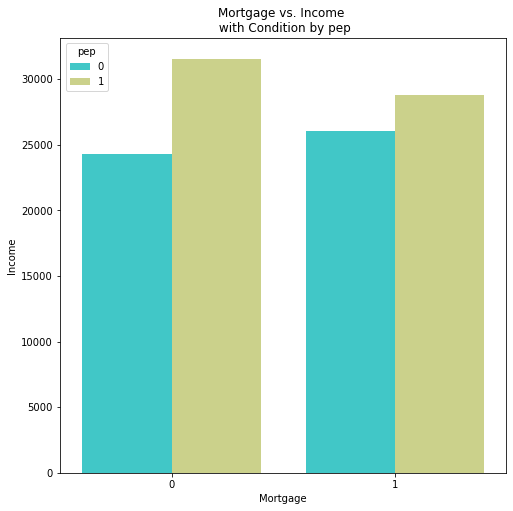

In [27]:
# Bar plot for house price vs house condition and number of bathrooms
ax = plt.figure(figsize=(8, 8))

g = sns.barplot(x = 'mortgage', y = 'income', 
           data = bank_df,             
           palette="rainbow",
           hue = "pep",
           ci = None)   
plt.xlabel('Mortgage')# Set text for x axis
plt.ylabel('Income')# Set text for y axis
g.legend(loc='upper left', bbox_to_anchor=(0.001,1 ),title = 'pep', ncol=1) # Set hue box to the upperleft of the plot
plt.title('Mortgage vs. Income \n with Condition by pep')# Set text for title
plt.show()

##### Customers who dont have a mortgage and have a income of more than 3000 are likely to say yes to the campaign

## Data Split

In [28]:
# Seperate train test set
bank_df_train, bank_df_tune_test = train_test_split(bank_df,
                                    test_size = 0.3,
                                    random_state = SEED,
                                    shuffle = True,
                                    stratify = None)

In [29]:
# further evenly split between tune and test
bank_df_tune, bank_df_test = train_test_split(bank_df_tune_test,
                                    test_size=0.5,
                                    random_state=SEED,
                                    shuffle=True,
                                    stratify=None)

In [30]:
# double check data dimensions after the split
print(bank_df.shape)
print(bank_df_train.shape)
print(bank_df_tune.shape)
print(bank_df_test.shape)

(600, 14)
(420, 14)
(90, 14)
(90, 14)


In [31]:
# Set the target train, tune and test values
y_train = bank_df_train["pep"].to_numpy()
y_tune = bank_df_tune["pep"].to_numpy()
y_test = bank_df_test["pep"].to_numpy()

In [32]:
# drop target to predict
bank_df_train = bank_df_train.drop(["pep"], axis=1)
bank_df_tune = bank_df_tune.drop(["pep"], axis=1)
bank_df_test = bank_df_test.drop(["pep"], axis=1)

In [33]:
# feature matrix
X_train = bank_df_train.to_numpy()
X_tune = bank_df_tune.to_numpy()
X_test = bank_df_test.to_numpy()

In [34]:
feature_names = bank_df_train.columns

## Train,Tune,Test and Evaluate Ensemble Model

### Metrics to Evaluate Models

In [35]:
def metrics(modelName,X_tune,y_tune):
    # predict probability on tune set
    y_tune_prob = modelName.predict_proba(X_tune)[:,1]

    # predict class label on tune set
    y_tune_pred = modelName.predict(X_tune)
    
    # print out confusion matrix
    cm = confusion_matrix(y_true=y_tune, y_pred=y_tune_pred)
    print(cm)
    
    # calculate accuracy 
    accuracyScoretune = accuracy_score(y_true=y_tune, y_pred=y_tune_pred)
    print('Accuracy of Tune Set : ' + str(accuracyScoretune))
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=y_tune, y_score=y_tune_prob)
    roc_auc = roc_auc_score(y_true=y_tune, y_score=y_tune_prob)

    plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
    plt.title("Receiver Operating Characteristic")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.show()
    

### SearchGridCV To Get Best Parameters for Tuning Models

In [36]:
# grid search
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=SEED),
    param_grid={
        "criterion": ["entropy", "gini"],
        "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
        "min_samples_leaf": [10, 20, 30, 40, 50],
        "n_estimators": [20, 50],
        'max_features': [0.10,0.25,0.50]
    },
    scoring="accuracy",
    n_jobs=10,
    cv=StratifiedKFold(n_splits=5, random_state=SEED),
    verbose=1,
    refit=True
)

# fit in training data
grid.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


C:\Users\priya\.conda\envs\uwdatasci420\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   21.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   33.2s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   48.6s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 2400 out of 2400 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2005, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [37]:
# Print the hyper parameters
print(grid.best_params_)

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 10, 'n_estimators': 50}


In [38]:
# best cross-validation score. 
print(grid.best_score_)

0.8357142857142857


### Random Forest Classifier with hyper parameters selected from GridSearchCV

In [39]:
# we fit random forest 
estimator_RF = RandomForestClassifier(n_estimators=50,
                                   max_features=0.5,
                                   criterion="entropy",
                                   max_depth=9,
                                   min_samples_leaf=10,
                                   n_jobs=10,
                                   random_state=SEED,
                                   verbose=1)

estimator_RF.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=9, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=10,
                       oob_score=False, random_state=2005, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.0s finished


[[41  6]
 [ 9 34]]
Accuracy of Tune Set : 0.8333333333333334


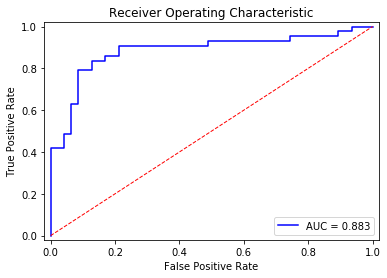

In [40]:
metrics(estimator_RF,X_tune,y_tune)

In [41]:
# random forests feature importance
len(estimator_RF.feature_importances_)

13

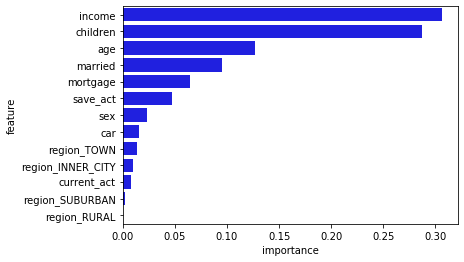

In [42]:
# plot feature importance
df_var_imp = pd.DataFrame({"feature": feature_names, 
                           "importance": estimator_RF.feature_importances_})
df_var_imp.sort_values(by="importance", ascending=False, inplace=True)

sns.barplot(x="importance", y="feature", data=df_var_imp.head(15), color="blue")

### Decision Tree Classifier

In [43]:
# Create a DT with Entropy criterion
base_estimator = DecisionTreeClassifier(criterion="entropy", max_depth=9,min_samples_leaf=10,random_state=SEED)
base_estimator.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2005, splitter='best')

In [44]:
# Show Tree method to display the Tree
def show_tree(out_name, model, feature_names):
    dotfile = open(out_name + ".dot", "w")
    export_graphviz(model, out_file=dotfile, filled=True, rounded=True, feature_names=feature_names)
    dotfile.close()

    os.system("dot -Tpng {}.dot -o {}.png".format(out_name, out_name))

    return(Image(filename=out_name + ".png", width=500, height=500))

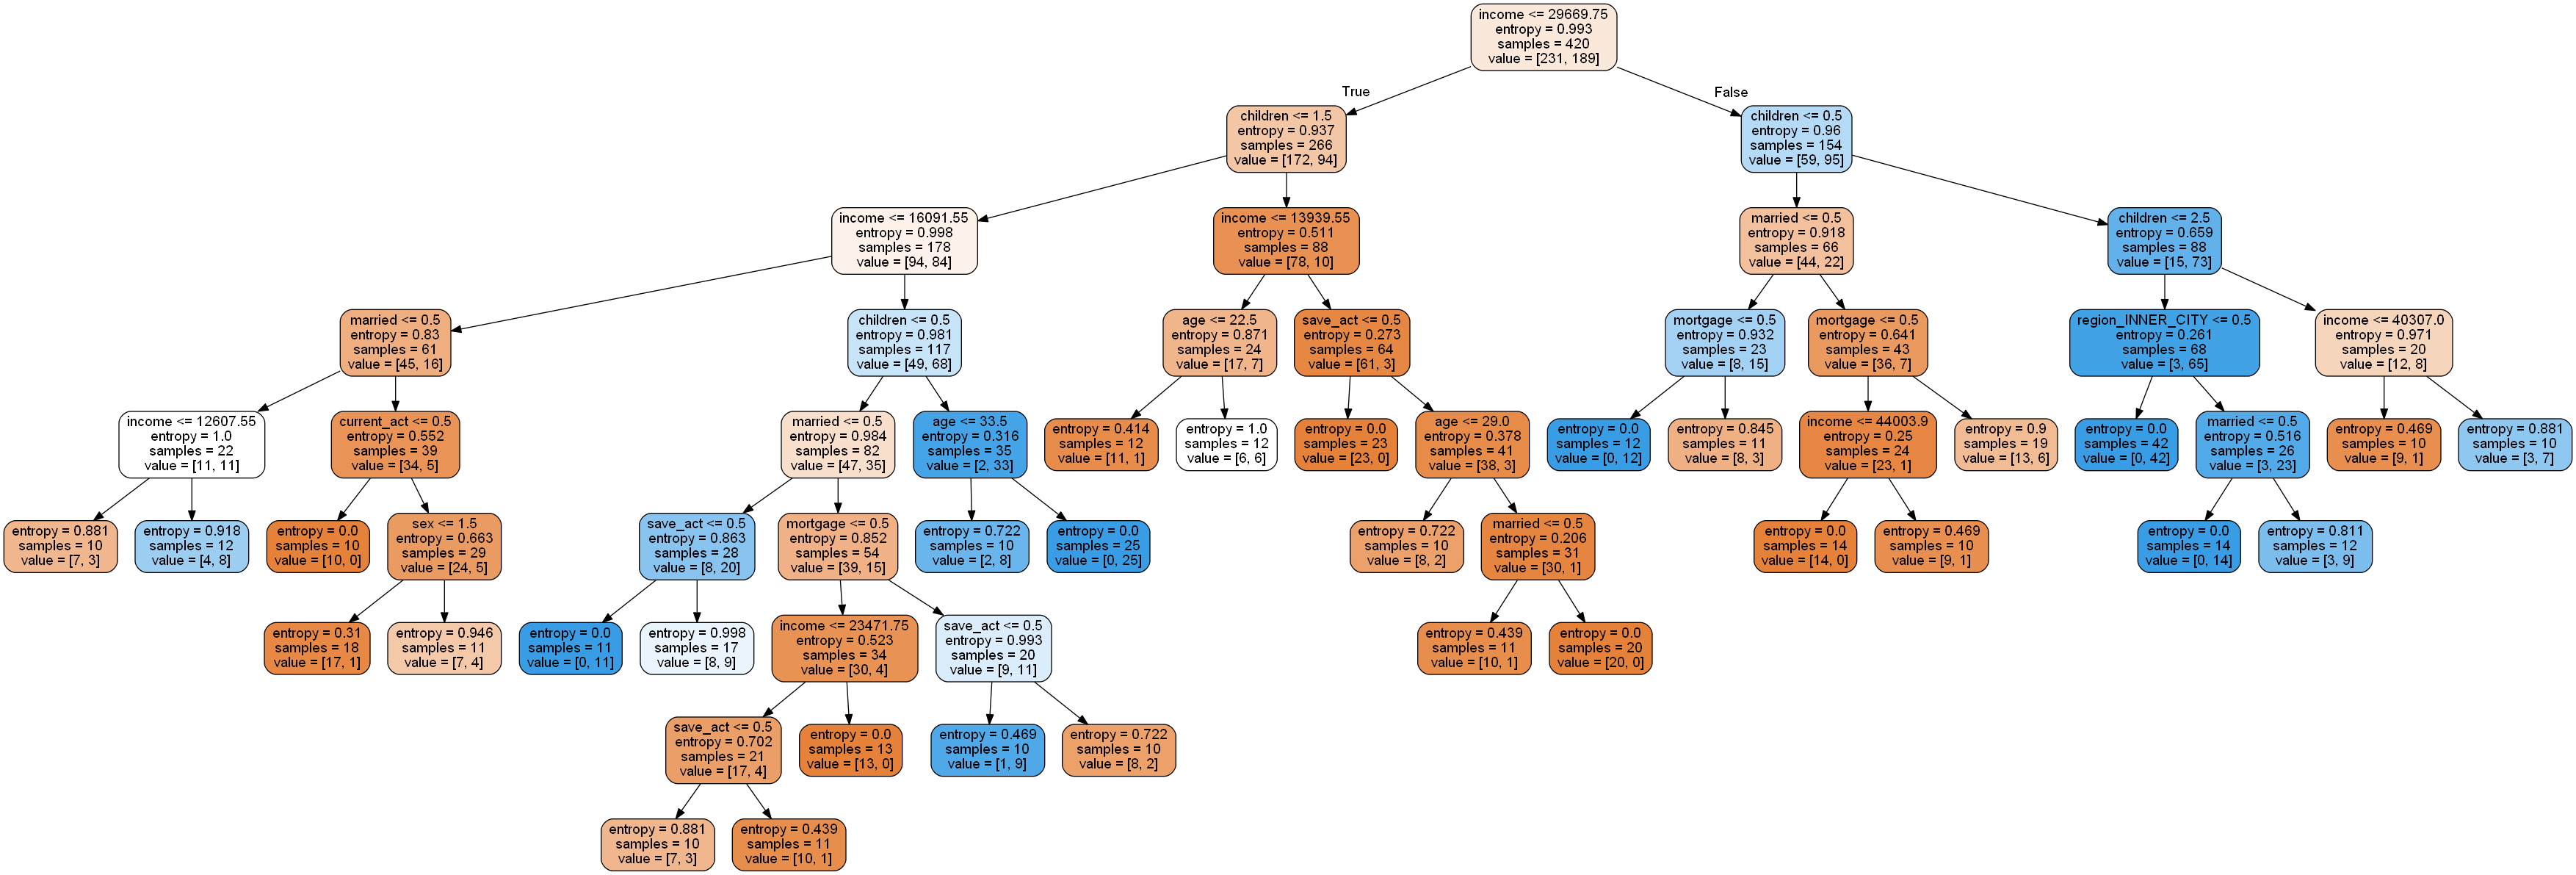

In [45]:
# Function call
show_tree("bank_tree_entropy", base_estimator, bank_df_train.columns)

#### Decision Tree Using Bagging Ensemble Learning Technique

In [46]:
# fit bagging with base estimator with the same hyper-parameters as in Random forest
estimator = BaggingClassifier(base_estimator=base_estimator,
                              n_estimators=50,
                              n_jobs=10,
                              oob_score=True,
                              random_state=SEED,
                              verbose=1)

estimator.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=9,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=10,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=2005,

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


[[42  5]
 [ 5 38]]
Accuracy of Tune Set : 0.8888888888888888


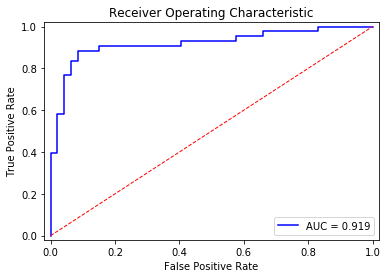

In [47]:
metrics(estimator,X_tune,y_tune)

In [48]:
# out-of-bag performance estimate
estimator.oob_score_

0.8666666666666667

#### Decision Tree Using Adaptive Boosting Ensemle Learning Technique

In [49]:
# AdaBoost
estimator_adaboost = AdaBoostClassifier(base_estimator=base_estimator, 
                               n_estimators=50, 
                               learning_rate=1.0, 
                               algorithm="SAMME.R", 
                               random_state=SEED)

estimator_adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=9,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=10,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                      

[[39  8]
 [13 30]]
Accuracy of Tune Set : 0.7666666666666667


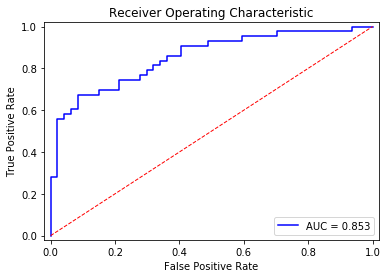

In [50]:
metrics(estimator_adaboost,X_tune,y_tune)

### Gradient Boosting

In [51]:
estimator_GB = GradientBoostingClassifier(learning_rate=0.01,
                                       n_estimators=50,
                                       max_depth=7,
                                       min_samples_leaf=10,
                                       max_features=0.5,
                                       random_state=SEED,
                                       verbose=1,
                                       validation_fraction=0.1,
                                       n_iter_no_change=5, 
                                       tol=1e-3)

estimator_GB.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3686            0.23s
         2           1.3598            0.22s
         3           1.3530            0.22s
         4           1.3399            0.22s
         5           1.3310            0.23s
         6           1.3233            0.24s
         7           1.3157            0.24s
         8           1.3063            0.23s
         9           1.2963            0.22s
        10           1.2886            0.21s
        20           1.2110            0.14s
        30           1.1431            0.10s
        40           1.0814            0.05s
        50           1.0239            0.00s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=7,
                           max_features=0.5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=2005, subsample=1.0, tol=0.001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [52]:
print(estimator_GB.n_estimators_)

50


[[44  3]
 [15 28]]
Accuracy of Tune Set : 0.8


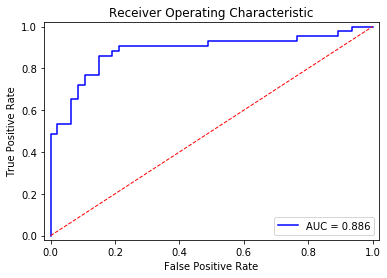

In [53]:
metrics(estimator_GB,X_tune,y_tune)

In [54]:
len(estimator_GB.feature_importances_)

13

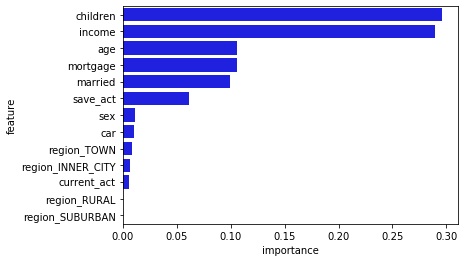

In [55]:
# plot feature importance
df_var_imp = pd.DataFrame({"feature": feature_names, 
                           "importance": estimator_GB.feature_importances_})
df_var_imp.sort_values(by="importance", ascending=False, inplace=True)

sns.barplot(x="importance", y="feature", data=df_var_imp.head(15), color="blue")

## Summary
 Decision tree using bagging ensemble model gives the best fit with Accuracy - 0.88, AUC - 0.91 after tuning the hyper parameters.

## Model performance in test set from the best model selected

In [56]:
# fit bagging with base estimator with the same hyper-parameters as in Random forest
estimator = BaggingClassifier(base_estimator=base_estimator,
                              n_estimators=50,
                              n_jobs=10,
                              oob_score=True,
                              random_state=SEED,
                              verbose=1)

estimator.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=9,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=10,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=2005,

In [57]:
# predict probability on test set
y_test_prob = estimator.predict_proba(X_test)[:,1]

# predict class label on test set
y_test_pred = estimator.predict(X_test)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [58]:
# print out confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[42  6]
 [ 4 38]]


In [59]:
# calculate accuracy 
accuracy_score(y_true=y_test, y_pred=y_test_pred)

0.8888888888888888

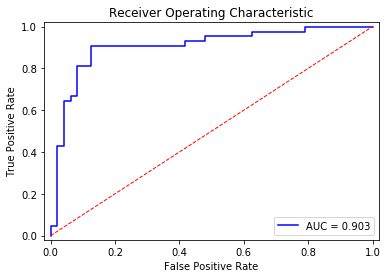

In [60]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_test_prob)
roc_auc = roc_auc_score(y_true=y_test, y_score=y_test_prob)

plt.plot(fpr, tpr, color="blue", label="AUC = %0.3f" % roc_auc)
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=1)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.show()

Test model accuracy - 0.88 & AUC - 0.90